## код model

In [1]:
"""
Full definition of a GPT Language Model, all of it in this single file.
References:
1) the official GPT-2 TensorFlow implementation released by OpenAI:
https://github.com/openai/gpt-2/blob/master/src/model.py
2) huggingface/transformers PyTorch implementation:
https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py
"""

import time as tm
t1_itogo = tm.time()
t1_temp = tm.time()

import math
import inspect
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F

import transformers

import matplotlib.pyplot as plt
import numpy as np  # for normalization

In [2]:

"""
Sample from a trained model
"""
import os
import pickle
from contextlib import nullcontext
import tiktoken

t2_temp = tm.time()
print('импорт библиотек занял', round(t2_temp - t1_temp)//60,'минут', 
      round(t2_temp - t1_temp)%60,'секунд')

импорт библиотек занял 0 минут 7 секунд


In [3]:
t1_temp = tm.time()

# def normalize_image(im):   прошлая версия функции normalize_image, ChatGPT предложил другую (см. ниже) 
                             #Чтобы исключить ошибки при операцией над скалирным массивом или числом 
#    im_res = im - np.min(im)
#    return (1 / np.max(im_res)) * im_res

def normalize_image(im: np.ndarray) -> np.ndarray:
    """Normalize array to [0,1] using min-max. Safe for constant arrays."""
    im = np.asarray(im)
    im_res = im - np.min(im)
    maxv = np.max(im_res)
    if maxv == 0:
        return np.zeros_like(im_res)
    return (1.0 / maxv) * im_res

In [4]:
class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))  # LayerNorm объект класса nn.Module и мы тут явно задаем nn.Parameter
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None # self.bias - 2это вектор смещений

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)

In [5]:
class CausalSelfAttention(nn.Module):# ме не задаем тут nn.Parameters, потому что они есть во вложенных слоях класса nn.Linear

    def __init__(self, config): #сonfig - что получили снаружи
        super().__init__()
        assert config.n_embd % config.n_head == 0 # а этот кусок что делает???
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias) #класс CausalSelfAttention содержит класс  self.c_attn
                                                                                     # раз тут есть слой класса nn.Linear 
                                                                                # то в нем уже есть "место" для атрибута nn.Parameter
                                                       #  self.c_attn у нас тот самый линейный слой, который превращает 
                                                     #входной промпт x = тензор размера BxTxC преобразуется в тензор размера BxTx3C
                                                     # то есть self.c_attn создает тензор размера BxTx3C
                                                    
                               # то есть этот слой занимается линейным преобразованием тензора промпта 
                               # при этом увеличивает его размерность
                                           # что из него мы потом сможем вырезаем Q, K и V, чтобы считать Attention 
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)   
                                        # c_proj обсуждаем вот здесь https://chatgpt.com/share/68f252f7-2460-8000-9461-0c92bdbb4dbb
                                        # но пока не понятно
                                                                             
        self.attn_dropout = nn.Dropout(config.dropout) # nn.Dropout специальный слой регуляризации в нейросетях, 
                                                    # который помогает модели не переобучаться.
                                                    # как работает, пока не важно
        self.resid_dropout = nn.Dropout(config.dropout) # Dropout  еще где-то работает. Пока не важно
        self.n_head = config.n_head # количество голов берем из config
        self.n_embd = config.n_embd # тут просто задается, что длина вектора  эмбеддинга (эмбеддинг = эмбеддинг токена) такая, 
                                    #  как задано в какой-то штуке config, которая подается на вход CausalSelfAttention
                                    # и с которой мы разберемся потом
        self.dropout = config.dropout # будем ли делать Dropout, берем из config
        
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention') # тут проверяется наличие функции 
                                                       # torch.nn.functional.scaled_dot_product_attention
                                                       # если она есть, то self.flash = True 
                                                      # и мы считаем Attention в forward через torch.nn.functional.scaled_dot_product_attention
                                                      # если этой функции нет - считаем Attention напрямую по формулам (см. def forward ... else...)
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)) 
                                        .view(1, 1, config.block_size, config.block_size))
            # register_buffer(name, tensor) — это метод базового класса nn.Module
            # он сохраняет тензор как часть состояния модели  и дает ему имя name
            # но это константа, он не учится. То есть он не входит в nn.Parameters, которые всегда обучаются
            # torch.ones(config.block_size, config.block_size) создает квадратную катрицу единиц
            # torch.tril(...) оставляет от этой матрицы только нижний треугольник, обнуляет все, что выше диагонали. 
            # .view(1, 1, block_size, block_size) добавляет фиктивныке измерения, 
            # то есть .view(1, 1, block_size, block_size) делает из матрицы (block_size, block_size)
            # матрицу (1, 1, block_size, block_size) 
            # и ее можно потом применять ко всем батчам batch и головам внимания (head) 
            # то есть self.register_buffer ( или self.bias???) и att будут иметь одинаковую размерность 

    def plot_weight_matrices(self, transpose: bool = True, show_qkv: bool = True, cmap: str = "coolwarm", normalize: bool = True):
        """
        Визуализирует матрицы весов внимания слоя: c_attn и c_proj с помощью plt.imshow.
        - transpose=True: приводим к «математическому» виду (C×3C для c_attn, C×C для c_proj),
          т.к. в PyTorch у Linear weight хранится как (out_features, in_features).
        - show_qkv: если True, разрезаем c_attn на W_q, W_k, W_v и показываем их отдельно;
                    если False — показываем только целиком c_attn и c_proj.
        - cmap: палитра для imshow.
        Возвращает (fig, axes).
        """
        with torch.no_grad():
            # c_attn: (out=3C, in=C) в виде хранения PyTorch
            W_cat = self.c_attn.weight.detach().cpu()
            if transpose:
                W_cat = W_cat.T  # теперь (C, 3C)
            C = self.n_embd
            # разрезаем на три блока по последней оси (если transpose=True это столбцы; иначе строки)
            if transpose:
                W_q, W_k, W_v = W_cat[:, :C], W_cat[:, C:2*C], W_cat[:, 2*C:]
            else:
                W_q, W_k, W_v = W_cat[:C, :], W_cat[C:2*C, :], W_cat[2*C:, :]

            # c_proj: (out=C, in=C) в хранении PyTorch
            W_proj = self.c_proj.weight.detach().cpu()
            if transpose:
                W_proj = W_proj.T  # хотим (C, C)

            # подбираем общие vmin/vmax для сравнимой цветовой шкалы
            import numpy as np
            mats = [W_cat, W_proj] + ([W_q, W_k, W_v] if show_qkv else [])
            if normalize:
                W_proj = normalize_image(W_proj)
                if show_qkv:
                    W_q, W_k, W_v = normalize_image(W_q), normalize_image(W_k), normalize_image(W_v)
                else:
                    W_cat = normalize_image(W_cat)
                vmin, vmax = 0.0, 1.0
            else:
                vmax = max(float(np.abs(m).max()) for m in mats)
                vmin = -vmax

            if show_qkv:
                fig, axes = plt.subplots(1, 4, figsize=(18, 4))
                ims = []
                im = axes[0].imshow(W_proj, aspect='auto', interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
                axes[0].set_title('c_proj weight')
                ims.append(im)
                im = axes[1].imshow(W_q, aspect='auto', interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
                axes[1].set_title('c_attn: W_q')
                ims.append(im)
                im = axes[2].imshow(W_k, aspect='auto', interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
                axes[2].set_title('c_attn: W_k')
                ims.append(im)
                im = axes[3].imshow(W_v, aspect='auto', interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
                axes[3].set_title('c_attn: W_v')
                ims.append(im)
                for ax in axes:
                    ax.set_xlabel('in features')
                    ax.set_ylabel('out features')
                fig.colorbar(ims[0], ax=axes, fraction=0.02)
            else:
                fig, axes = plt.subplots(1, 2, figsize=(10, 4))
                im0 = axes[0].imshow(W_proj, aspect='auto', interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
                axes[0].set_title('c_proj weight')
                im1 = axes[1].imshow(W_cat, aspect='auto', interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
                axes[1].set_title('c_attn (concat Q|K|V)')
                for ax in axes:
                    ax.set_xlabel('in features')
                    ax.set_ylabel('out features')
                fig.colorbar(im0, ax=axes, fraction=0.02)
        return fig, axes
    # ⟦ADDED END⟧ конец метода plot_weight_matrices
    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dim
                            # тут рассчитываем размерность промпта = размерность тензора скрытых состояний токенов.
                            #  первый раз туда попадает начальное скрытой состояние tok_emb + pos_emb
                            # а потом уже скрытые состояния токенов, которые вышли из прошлого блока Block
                            #B = batch size = количество батчей. Для обученния (где model тоже используется), их обычно несколько
                            # чтобы учиться одновременно на разных промптах
                             
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)  # тут у нас две операции (то есть сложная функция)
                                                            # сначала self.c_attn беред на вход тенезор размера BxTxC 
                                                             # и преобразует его в тензор BxTx3C
                                                             # а потом методод сплит режет его по второй оси, где у нас как раз 3C  
                                                             # на вектора длины C, то есть self.n_embd, которые мы получили из config
         
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  #тут происхордит "деление на головы"
                                                                 # когда длина эмбеддинга токена (она же ширина модели, она же hidden size
                                                        # раскраивается-разрезается на количество голов , то есть на число self.head)
                               # после разбиения каждый из тензоров q, k и v становится 4-мерным тензором формы (B, n_head, T, head_dim)
                                    # где  , как и раньше B - размер баптча, а  T - длина последовательности токенов
                            # но теперь вместо одного измерения C (=длина эмбеддинга) 
                             # возникает количество голов n_head и порция признаков на одну голову C // n_head
                             # все это количество голов, как и B, T и С берется из config
        
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)

    # ⬅️ Добавим это
        self.last_k = k.detach().cpu()
        self.last_q = q.detach().cpu()
        self.last_v = v.detach().cpu()

        if self.flash: # готовая функция для Attention - формул внизу, которые идет после else
                       # если в версии PyTorch уже есть эта готовая функция - используем ее, если нет, то считаем "вручную" по формулам ниже
            y = torch.nn.functional.scaled_dot_product_attention(
            q, k, v, attn_mask=None,
            dropout_p=self.dropout if self.training else 0,
            is_causal=True)
        else: # если нет готовой функции torch.nn.functional.scaled_dot_product_attention, 
            # то ниже прямой расчет внимания через прямые формулы
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1))) # Это сырые логиты внимания,
                                                                              # насколько каждый токен t_query «похож» на каждый токен t_key.
            att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf')) # для верхнетреугольной части (будущее") логиты заменяются на -inf
                                                                                # после softmax это превратится в 0 и это "запрет загабывать вперед"
                                                            # то есть каждый токен смотрит только не предыдущие токены, а на те, что после него - нет
            att = F.softmax(att, dim=-1) # перевод значания в вероятность
            att = self.attn_dropout(att) # в режиме обучение зануление части вероятностей для профилавктики переобучения.
                                         # Как работает, пока не знаю
            y = att @ v   #а что за y мы получили???

        y = y.transpose(1, 2).contiguous().view(B, T, C)   # Склеиваем головыn внимания обратно: (B, H, T, Dh) → (B, T, H*Dh=C)
                                                         # что за размерность Dh??? Зачем нужны головы внимания?  
        y = self.resid_dropout(self.c_proj(y))
        return y


t2_temp = tm.time()
print('этот блок занял', round(t2_temp - t1_temp)//60,'минут', 
      round(t2_temp - t1_temp)%60,'секунд')

этот блок занял 0 минут 0 секунд


In [6]:
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

In [7]:
class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x


In [8]:
@dataclass
class GPTConfig:
    block_size: int = 1024
    vocab_size: int = 50304 # GPT-2 vocab_size of 50257, padded up to nearest multiple of 64 for efficiency
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768
    dropout: float = 0.0
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster


In [9]:
class GPT(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        # with weight tying when using torch.compile() some warnings get generated:
        # "UserWarning: functional_call was passed multiple values for tied weights.
        # This behavior is deprecated and will be an error in future versions"
        # not 100% sure what this is, so far seems to be harmless. TODO investigate
        self.transformer.wte.weight = self.lm_head.weight # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None): # именно здесь у нас входной текст превращается в тензиор эмбеддингов BxTxC ,
                                          # который объединяет токенные и позиционные эмбеддинги
                                          # то есть является их суммой 
        
                                          # изначально idx - двухмерный тензор размера BxT
                                          # для каждого батча и токена он указывает номер токена в словаре
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
                   #self.transformer.wte - функция в подклассе self.tramsformer
                  # превращает индекс токенов idx в вектор токенных эмбеддингов
                    # размерность одного токена C = n_embd, размерность tok_emb =  BxTxC
                    #правильное название Batch of embeddings: (B, T, C)
                    # но используют и формулировку "токенный     эмбеддинг", имея в виду тип представления, а не конкретную форму
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss

    def crop_block_size(self, block_size):
        # model surgery to decrease the block size if necessary
        # e.g. we may load the GPT2 pretrained model checkpoint (block size 1024)
        # but want to use a smaller block size for some smaller, simpler model
        assert block_size <= self.config.block_size
        self.config.block_size = block_size
        self.transformer.wpe.weight = nn.Parameter(self.transformer.wpe.weight[:block_size])
        for block in self.transformer.h:
            if hasattr(block.attn, 'bias'):
                block.attn.bias = block.attn.bias[:,:,:block_size,:block_size]

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints
        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = GPT(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                assert sd_hf[k].shape == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k])

        return model

    def configure_optimizers(self, weight_decay, learning_rate, betas, device_type):
        # start with all of the candidate parameters
        param_dict = {pn: p for pn, p in self.named_parameters()}
        # filter out those that do not require grad
        param_dict = {pn: p for pn, p in param_dict.items() if p.requires_grad}
        # create optim groups. Any parameters that is 2D will be weight decayed, otherwise no.
        # i.e. all weight tensors in matmuls + embeddings decay, all biases and layernorms don't.
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        nodecay_params = [p for n, p in param_dict.items() if p.dim() < 2]
        optim_groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': nodecay_params, 'weight_decay': 0.0}
        ]
        num_decay_params = sum(p.numel() for p in decay_params)
        num_nodecay_params = sum(p.numel() for p in nodecay_params)
        print(f"num decayed parameter tensors: {len(decay_params)}, with {num_decay_params:,} parameters")
        print(f"num non-decayed parameter tensors: {len(nodecay_params)}, with {num_nodecay_params:,} parameters")
        # Create AdamW optimizer and use the fused version if it is available
        fused_available = 'fused' in inspect.signature(torch.optim.AdamW).parameters
        use_fused = fused_available and device_type == 'cuda'
        extra_args = dict(fused=True) if use_fused else dict()
        optimizer = torch.optim.AdamW(optim_groups, lr=learning_rate, betas=betas, **extra_args)
        print(f"using fused AdamW: {use_fused}")

        return optimizer

    def estimate_mfu(self, fwdbwd_per_iter, dt):
        """ estimate model flops utilization (MFU) in units of A100 bfloat16 peak FLOPS """
        # first estimate the number of flops we do per iteration.
        # see PaLM paper Appendix B as ref: https://arxiv.org/abs/2204.02311
        N = self.get_num_params()
        cfg = self.config
        L, H, Q, T = cfg.n_layer, cfg.n_head, cfg.n_embd//cfg.n_head, cfg.block_size
        flops_per_token = 6*N + 12*L*H*Q*T
        flops_per_fwdbwd = flops_per_token * T
        flops_per_iter = flops_per_fwdbwd * fwdbwd_per_iter
        # express our flops throughput as ratio of A100 bfloat16 peak flops
        flops_achieved = flops_per_iter * (1.0/dt) # per second
        flops_promised = 312e12 # A100 GPU bfloat16 peak flops is 312 TFLOPS
        mfu = flops_achieved / flops_promised
        return mfu

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.config.block_size else idx[:, -self.config.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)

        return idx


In [10]:
import torch

cfg = GPTConfig(block_size=8, vocab_size=64, n_layer=2, n_head=2, n_embd=16, dropout=0.0, bias=True)
m = GPT(cfg).eval()

x = torch.randint(0, cfg.vocab_size, (1, 8))
with torch.no_grad():
    logits, loss = m(x, x)

print("OK:", logits.shape, "loss:", float(loss))


number of parameters: 0.01M
OK: torch.Size([1, 8, 64]) loss: 3.906500816345215


In [11]:
def show_attn_weight_matrices(
    model: GPT, layer_idx: int, transpose: bool = True, show_qkv: bool = True, cmap: str = "coolwarm", normalize: bool = True):
    """
    Удобная обёртка: показываем weight-матрицы внимания (c_attn и c_proj) для блока с индексом layer_idx.
    Пример использования:
        fig, axes = show_attn_weight_matrices(model, layer_idx=0)
        plt.show()
    """
    attn = model.transformer.h[layer_idx].attn
    return attn.plot_weight_matrices(transpose=transpose, show_qkv=show_qkv, cmap=cmap, normalize=normalize)

In [12]:
# Проверяем generate
start_tok = torch.randint(0, cfg.vocab_size, (1, 1))  # один случайный токен-старт
print("Start token:", start_tok.tolist())

with torch.no_grad():
    out = m.generate(start_tok, max_new_tokens=10)  # сгенерируем 10 новых токенов

print("Generated sequence:", out.tolist())


Start token: [[6]]
Generated sequence: [[6, 23, 40, 9, 19, 19, 5, 55, 28, 5, 8]]


In [13]:
# ======== utils: извлечение и сравнение Wq/Wk/Wv по диапазону блоков ========
def _extract_WqWkWv_from_attn(attn, *, transpose_for_math: bool = True):
    """
    Возвращает (Wq, Wk, Wv, C, n_head, head_dim) для данного attn-модуля.
    - Если transpose_for_math=True → Wcat в виде (in=C, out=3C), режем по столбцам.
    - Иначе оставляем pytorch-вид (out=3C, in=C), режем по строкам.
    """
    Wcat = attn.c_attn.weight.detach().cpu()  # (3C, C) в PT-представлении (out, in)
    C = attn.n_embd
    n_head = attn.n_head
    head_dim = C // n_head

    if transpose_for_math:
        Wcat = Wcat.t()                       # (C, 3C): (in, out)
        Wq = Wcat[:, 0*C:1*C]                 # (C, C)
        Wk = Wcat[:, 1*C:2*C]                 # (C, C)
        Wv = Wcat[:, 2*C:3*C]                 # (C, C)
        split_axis = "col"                    # головы → по столбцам
    else:
        Wq = Wcat[0*C:1*C, :]                 # (C, C)
        Wk = Wcat[1*C:2*C, :]                 # (C, C)
        Wv = Wcat[2*C:3*C, :]                 # (C, C)
        split_axis = "row"                    # головы → по строкам

    return Wq, Wk, Wv, C, n_head, head_dim, split_axis

In [14]:

def _slice_head(W, h, head_dim, split_axis: str):
    """
    Возвращает срез матрицы W для головы h.
    - Если split_axis == 'row'  → берём строки [h*head_dim : (h+1)*head_dim, :]
    - Если split_axis == 'col'  → берём столбцы [:, h*head_dim : (h+1)*head_dim]
    """
    if split_axis == "row":
        return W[h*head_dim:(h+1)*head_dim, :]
    elif split_axis == "col":
        return W[:, h*head_dim:(h+1)*head_dim]
    else:
        raise ValueError("split_axis must be 'row' or 'col'")

In [15]:
def _cosine_sim(a: torch.Tensor, b: torch.Tensor, eps: float = 1e-9) -> float:
    a = a.flatten()
    b = b.flatten()
    return (a @ b).item() / ((a.norm() + eps) * (b.norm() + eps))


In [16]:
def _procrustes_error(A: torch.Tensor, B: torch.Tensor, eps: float = 1e-9) -> float:
    """
    Procrustes: ищем ортогональный R, минимизирующий ||A - B R||_F / ||A||_F.
    Важно: форма A и B должна позволять умножение B @ R.
    Для устойчивости ожидаем, что W головы идёт как (head_dim, C) либо (C, head_dim).
    Если ты работаешь в режиме split_axis='col' (головы по столбцам), то W_slice имеет форму (C, head_dim).
    Тогда подгоняем к виду (head_dim, C), чтобы B.T @ A имел форму (head_dim, head_dim).
    """
    # Приведём к виду (head_dim, C)
    if A.shape[0] < A.shape[1]:   # (head_dim, C)
        A_use = A
    else:                         # (C, head_dim) → транспонируем
        A_use = A.t()
    if B.shape[0] < B.shape[1]:
        B_use = B
    else:
        B_use = B.t()

    # Теперь A_use,B_use: (head_dim, C)
    M = B_use.T @ A_use           # (C, C) → SVD
    U, _, Vt = torch.linalg.svd(M, full_matrices=False)
    R = U @ Vt
    num = (A_use - B_use @ R).norm()
    den = A_use.norm() + eps
    return (num / den).item()



In [17]:
def _greedy_match_heads(W_l, W_lp1, head_dim, split_axis: str):
    """
    Жадное сопоставление голов между соседними слоями по косинусной похожести.
    Возвращает список пар (h_in_l, matched_h_in_lp1)
    и матрицу похожестей (n_head x n_head).
    """
    if split_axis == "row":
        n_head = W_l.shape[0] // head_dim
    else:
        n_head = W_l.shape[1] // head_dim

    # считаем матрицу косинусов между всеми головами
    sims = torch.empty(n_head, n_head)
    for h0 in range(n_head):
        a = _slice_head(W_l,   h0, head_dim, split_axis)
        for h1 in range(n_head):
            b = _slice_head(W_lp1, h1, head_dim, split_axis)
            sims[h0, h1] = _cosine_sim(a, b)

    # жадное сопоставление: для каждой головы в l берём наилучшую в l+1,
    # не позволяя двум разным головам взять одну и ту же пару
    matched = [-1] * n_head
    taken = set()
    for h0 in range(n_head):
        # выбираем h1 с максимальным косинусом, который ещё не взят
        best_h1 = None
        best_val = -1e9
        for h1 in range(n_head):
            if h1 in taken:
                continue
            val = sims[h0, h1].item()
            if val > best_val:
                best_val, best_h1 = val, h1
        matched[h0] = best_h1
        taken.add(best_h1)

    pairs = [(h0, matched[h0]) for h0 in range(n_head)]
    return pairs, sims


def compare_blocks_range(
    model,
    start_idx: int,
    end_idx: int,
    *,
    which: str = "q",                 # 'q' | 'k' | 'v'
    transpose_for_math: bool = True,  # как вырезаем головы (см. extract)
    plot: bool = True,
    title: str | None = None,
):
    """
    Сравнивает выбранный тип весов (q/k/v) между соседними блоками на диапазоне [start_idx, end_idx].
    Для каждой пары слоёв l -> l+1:
      1) жадно сопоставляет головы по косинусу;
      2) считает косинус и Procrustes-ошибку по каждой сопоставленной голове;
      3) усредняет метрики по головам.
    Возвращает словарь с метриками и (опц.) рисует графики средних метрик по слоям.
    """
    assert 0 <= start_idx < end_idx < len(model.transformer.h), "Проверь границы диапазона"
    assert which in {"q", "k", "v"}

    avg_cosines = []      # средний косинус по головам для каждой пары слоёв
    avg_procr = []        # средняя Procrustes-ошибка по головам
    layer_pairs = []      # список пар (l, l+1), чтобы подписывать ось X

    for l in range(start_idx, end_idx):
        attn_l   = model.transformer.h[l].attn
        attn_lp1 = model.transformer.h[l+1].attn

        Wq_l, Wk_l, Wv_l, C, n_head, head_dim, split_axis = _extract_WqWkWv_from_attn(
            attn_l, transpose_for_math=transpose_for_math
        )
        Wq_p, Wk_p, Wv_p, *_ = _extract_WqWkWv_from_attn(
            attn_lp1, transpose_for_math=transpose_for_math
        )

        W_l  = {"q": Wq_l, "k": Wk_l, "v": Wv_l}[which]
        W_p1 = {"q": Wq_p, "k": Wk_p, "v": Wv_p}[which]

        # сопоставляем головы
        pairs, sims_mat = _greedy_match_heads(W_l, W_p1, head_dim, split_axis)

        cos_vals = []
        pro_vals = []
        for h0, h1 in pairs:
            A = _slice_head(W_l,  h0, head_dim, split_axis)
            B = _slice_head(W_p1, h1, head_dim, split_axis)
            cos_vals.append(_cosine_sim(A, B))
            pro_vals.append(_procrustes_error(A, B))

        avg_cosines.append(float(torch.tensor(cos_vals).mean()))
        avg_procr.append(float(torch.tensor(pro_vals).mean()))
        layer_pairs.append((l, l+1))

    metrics = {
        "layer_pairs": layer_pairs,
        "avg_cosine":  avg_cosines,
        "avg_procrustes": avg_procr,
        "which": which,
        "transpose_for_math": transpose_for_math,
    }

    if plot:
        xs = list(range(len(layer_pairs)))
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        axes[0].plot(xs, avg_cosines, marker="o")
        axes[0].set_title(f"Средний косинус по головам ({which})")
        axes[0].set_xlabel("пара слоёв l→l+1")
        axes[0].set_ylabel("cosine")
        axes[0].set_xticks(xs, [f"{l}→{lp1}" for (l, lp1) in layer_pairs], rotation=0)

        axes[1].plot(xs, avg_procr, marker="o")
        axes[1].set_title(f"Средняя Procrustes-ошибка по головам ({which})")
        axes[1].set_xlabel("пара слоёв l→l+1")
        axes[1].set_ylabel("error (↓ лучше)")
        axes[1].set_xticks(xs, [f"{l}→{lp1}" for (l, lp1) in layer_pairs], rotation=0)

        if title:
            fig.suptitle(title, y=1.03)
        fig.tight_layout()
        metrics["figure"] = fig
        metrics["axes"] = axes

    return metrics

In [18]:

def compare_blocks_range_all_three(
    model,
    start_idx: int,
    end_idx: int,
    *,
    transpose_for_math: bool = True,
    plot: bool = True,
    suptitle: str | None = None,
):
    """
    Удобная «панель»: запускает сравнение для q, k, v и рисует 2x3 графика:
      (cos_q, cos_k, cos_v) и (proc_q, proc_k, proc_v).
    Возвращает словарь с тремя наборами метрик.
    """
    res_q = compare_blocks_range(
        model, start_idx, end_idx, which="q",
        transpose_for_math=transpose_for_math, plot=False
    )
    res_k = compare_blocks_range(
        model, start_idx, end_idx, which="k",
        transpose_for_math=transpose_for_math, plot=False
    )
    res_v = compare_blocks_range(
        model, start_idx, end_idx, which="v",
        transpose_for_math=transpose_for_math, plot=False
    )

    if plot:
        xs = list(range(len(res_q["layer_pairs"])))
        fig, axes = plt.subplots(2, 3, figsize=(14, 6))
        # cosines
        axes[0,0].plot(xs, res_q["avg_cosine"], marker="o"); axes[0,0].set_title("cos(q)")
        axes[0,1].plot(xs, res_k["avg_cosine"], marker="o"); axes[0,1].set_title("cos(k)")
        axes[0,2].plot(xs, res_v["avg_cosine"], marker="o"); axes[0,2].set_title("cos(v)")
        # procrustes
        axes[1,0].plot(xs, res_q["avg_procrustes"], marker="o"); axes[1,0].set_title("proc(q) ↓")
        axes[1,1].plot(xs, res_k["avg_procrustes"], marker="o"); axes[1,1].set_title("proc(k) ↓")
        axes[1,2].plot(xs, res_v["avg_procrustes"], marker="o"); axes[1,2].set_title("proc(v) ↓")

        for ax in axes.flatten():
            ax.set_xlabel("пара слоёв l→l+1")
            ax.set_xticks(xs, [f"{l}→{lp1}" for (l, lp1) in res_q["layer_pairs"]], rotation=0)

        if suptitle:
            fig.suptitle(suptitle, y=1.03)
        fig.tight_layout()

        return {"q": res_q, "k": res_k, "v": res_v, "figure": fig, "axes": axes}
    else:
        return {"q": res_q, "k": res_k, "v": res_v}
# ======== end utils ========



## Тут заканчивается код model и начинается код sample 

In [19]:
t1_temp = tm.time()

# -----------------------------------------------------------------------------
init_from = 'gpt2' # either 'resume' (from an out_dir) or a gpt2 variant (e.g. 'gpt2-xl')
out_dir = 'out' # ignored if init_from is not 'resume'
start_prompt = "quick_sort in Python is " # or "<|endoftext|>" or etc. Can also specify a file, use as: "FILE:prompt.txt"
num_samples = 1 # number of samples to draw
max_new_tokens = 1 # number of tokens generated in each sample
temperature = 0.8 # 1.0 = no change, < 1.0 = less random, > 1.0 = more random, in predictions
top_k = 2 # retain only the top_k most likely tokens, clamp others to have 0 probability
seed = 1337
device = 'cpu' # examples: 'cpu', 'cuda', 'cuda:0', 'cuda:1', etc.
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
compile = False # use PyTorch 2.0 to compile the model to be faster
#exec(open('configurator.py').read()) # overrides from command line or config file
# -----------------------------------------------------------------------------

t2_temp = tm.time()
print('при количестве создаваемых токенов ', max_new_tokens , 'и прогонов ', num_samples, 'этот блок занял', round(t2_temp - t1_temp)//60,'минут', 
      round(t2_temp - t1_temp)%60,'секунд')

при количестве создаваемых токенов  1 и прогонов  1 этот блок занял 0 минут 0 секунд


In [20]:
t1_temp = tm.time()

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

t2_temp = tm.time()
print('при количестве создаваемых токенов ', max_new_tokens , 'и прогонов ', num_samples, 'этот блок занял', round(t2_temp - t1_temp)//60,'минут', 
      round(t2_temp - t1_temp)%60,'секунд')

при количестве создаваемых токенов  1 и прогонов  1 этот блок занял 0 минут 0 секунд


In [21]:
t1_temp = tm.time()

# model
if init_from == 'resume':
    # init from a model saved in a specific directory
    ckpt_path = os.path.join(out_dir, 'ckpt.pt')
    checkpoint = torch.load(ckpt_path, map_location=device)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
elif init_from.startswith('gpt2'):
    # init from a given GPT-2 model
    model = GPT.from_pretrained(init_from, dict(dropout=0.0))

t2_temp = tm.time()
print('при количестве создаваемых токенов ', max_new_tokens , 'и прогонов ', num_samples, 'этот блок занял', round(t2_temp - t1_temp)//60,'минут', 
      round(t2_temp - t1_temp)%60,'секунд')

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.0
number of parameters: 123.65M
при количестве создаваемых токенов  1 и прогонов  1 этот блок занял 0 минут 10 секунд


In [22]:
t1_temp = tm.time()

model.eval()
model.to(device)
if compile:
    model = torch.compile(model) # requires PyTorch 2.0 (optional)

t2_temp = tm.time()
print('при количестве создаваемых токенов ', max_new_tokens , 'и прогонов ', num_samples, 'этот блок занял', round(t2_temp - t1_temp)//60,'минут', 
      round(t2_temp - t1_temp)%60,'секунд')

при количестве создаваемых токенов  1 и прогонов  1 этот блок занял 0 минут 0 секунд


In [23]:
t1_temp = tm.time()

# look for the meta pickle in case it is available in the dataset folder
load_meta = False
if init_from == 'resume' and 'config' in checkpoint and 'dataset' in checkpoint['config']: # older checkpoints might not have these...
    meta_path = os.path.join('data', checkpoint['config']['dataset'], 'meta.pkl')
    load_meta = os.path.exists(meta_path)
if load_meta:
    print(f"Loading meta from {meta_path}...")
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
else:
    # ok let's assume gpt-2 encodings by default
    print("No meta.pkl found, assuming GPT-2 encodings...")
    enc = tiktoken.get_encoding("gpt2")
    encode = lambda s: enc.encode(s, allowed_special={"<|endoftext|>"})
    decode = lambda l: enc.decode(l)

t2_temp = tm.time()
print('при количестве создаваемых токенов ', max_new_tokens , 'и прогонов ', num_samples, 'этот блок занял', round(t2_temp - t1_temp)//60,'минут', 
      round(t2_temp - t1_temp)%60,'секунд')

No meta.pkl found, assuming GPT-2 encodings...
при количестве создаваемых токенов  1 и прогонов  1 этот блок занял 0 минут 0 секунд


In [24]:
t1_temp = tm.time()

start_ids = encode(start_prompt)

# encode the beginning of the prompt
if start_prompt.startswith('FILE:'):
    with open(start_prompt[5:], 'r', encoding='utf-8') as f:
        start = f.read()

# >>> Добавляем отладочный вывод токенизации промпта
print("\n🧩 Токенизация промпта:")
print("Промпт:", repr(start_prompt))
print("Список ID:", start_ids)


try:
    # если ты используешь tiktoken, можно показать каждый токен и его байтовое представление
    for i, tid in enumerate(start_ids):
        bs = enc.decode_single_token_bytes(tid)
        try:
            frag = bs.decode("utf-8")
        except UnicodeDecodeError:
            frag = str(bs)
        safe = frag.replace(" ", "␠").replace("\n", "⏎")
        print(f"{i:>3} | id={tid:>5} | токен={safe!r}")
except Exception:
    # fallback для случая, если meta.pkl используется
    print("Токены:", [decode([tid]) for tid in start_ids])

x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])

# run generation
with torch.no_grad():
    with ctx:
        for k in range(num_samples):
            y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
            print(decode(y[0].tolist()))
            print('---------------')




🧩 Токенизация промпта:
Промпт: 'quick_sort in Python is '
Список ID: [24209, 62, 30619, 287, 11361, 318, 220]
  0 | id=24209 | токен='quick'
  1 | id=   62 | токен='_'
  2 | id=30619 | токен='sort'
  3 | id=  287 | токен='␠in'
  4 | id=11361 | токен='␠Python'
  5 | id=  318 | токен='␠is'
  6 | id=  220 | токен='␠'
quick_sort in Python is  
---------------


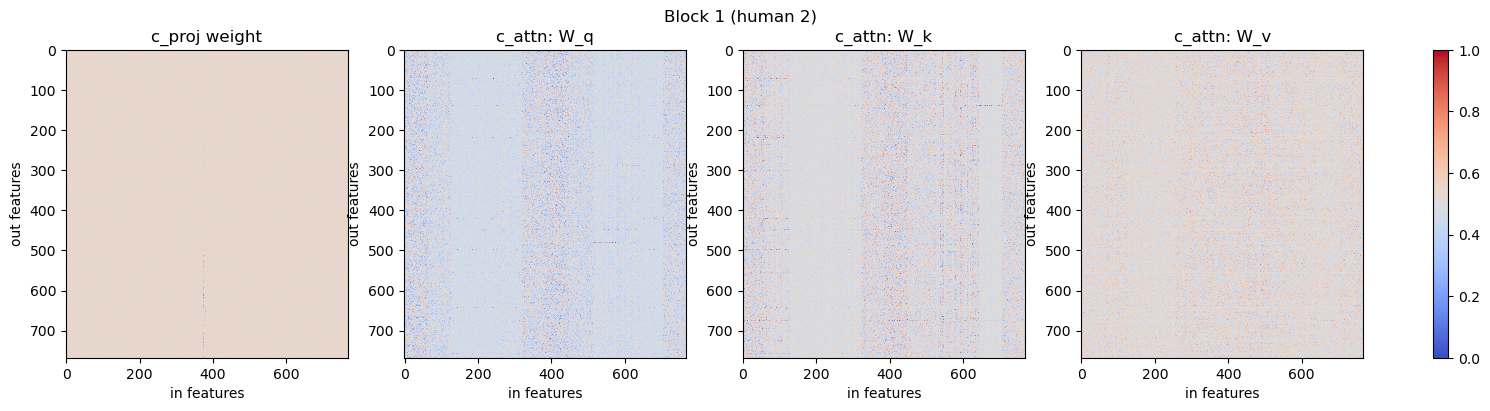

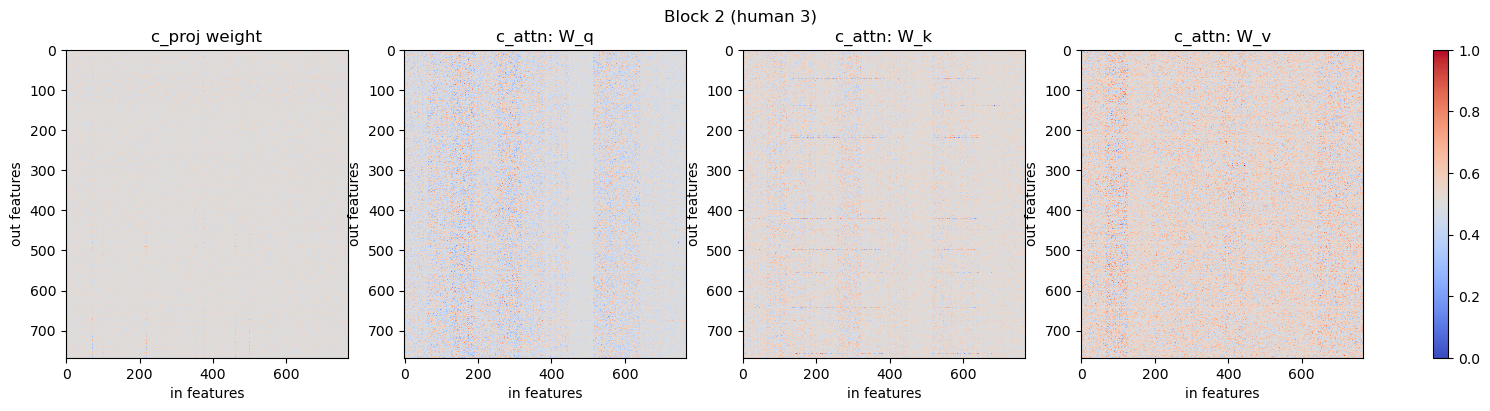

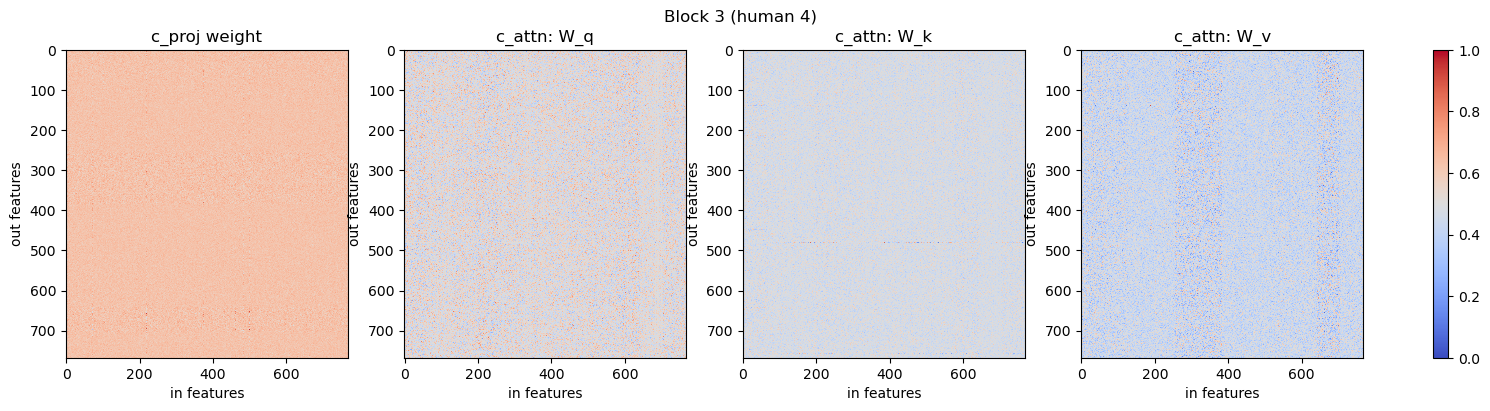

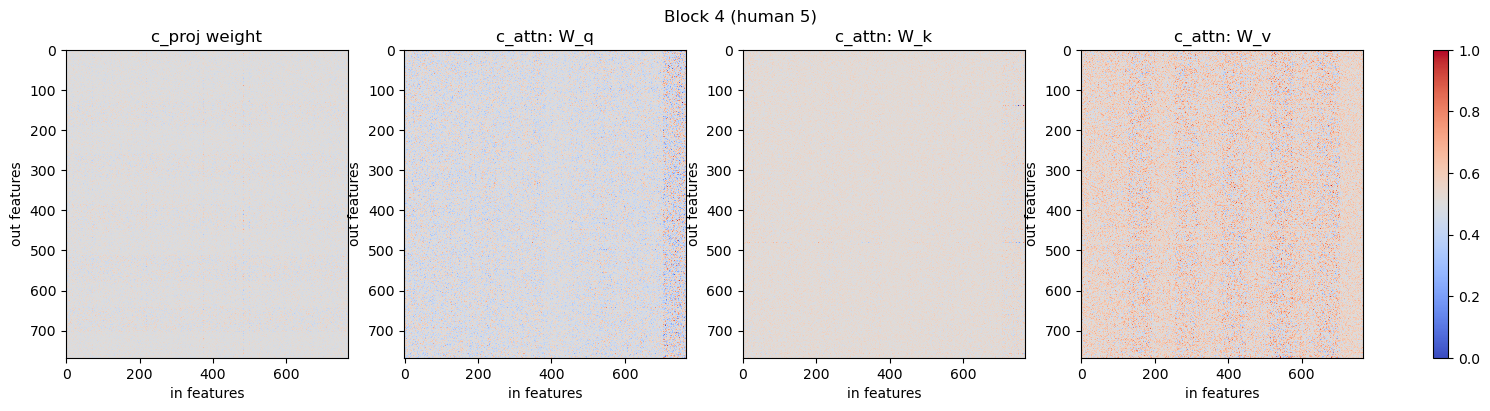

In [25]:
human_start = 2
human_end   = 5
start_idx   = human_start - 1
end_idx     = human_end - 1
n_blocks = len(model.transformer.h)
start_idx = max(0, start_idx)
end_idx   = min(n_blocks - 1, end_idx)
assert start_idx <= end_idx, "Пустой диапазон блоков"

for i in range(start_idx, end_idx + 1):
    fig, axes = show_attn_weight_matrices(model, layer_idx=i)
    fig.suptitle(f"Block {i} (human {i+1})")

In [36]:
def show_attn_weight_matrices_delta(
    model: GPT,
    layer_idx: int,
    transpose: bool = True,
    show_qkv: bool = True,
    cmap: str = "coolwarm",
    normalize: bool = True,
):
    """
    Показываем Δ весов внимания между блоками (layer_idx+1) и (layer_idx).
    """
    n_blocks = len(model.transformer.h)
    assert 0 <= layer_idx < n_blocks - 1, "layer_idx must be <= n_blocks-2 (нужны соседние слои)"

    attn2 = model.transformer.h[layer_idx].attn      # earlier layer (i)
    attn1 = model.transformer.h[layer_idx + 1].attn  # later   layer (i+1)

    # Compute parameter deltas (stop autograd; we’re just visualizing)
    with torch.no_grad():
        d_c_attn_w = attn1.c_attn.weight.detach() - attn2.c_attn.weight.detach()
        d_c_proj_w = attn1.c_proj.weight.detach() - attn2.c_proj.weight.detach()
        d_c_attn_b = None
        d_c_proj_b = None
        if attn1.c_attn.bias is not None:
            d_c_attn_b = attn1.c_attn.bias.detach() - attn2.c_attn.bias.detach()
        if attn1.c_proj.bias is not None:
            d_c_proj_b = attn1.c_proj.bias.detach() - attn2.c_proj.bias.detach()

    # Minimal proxy that looks like a CausalSelfAttention for plotting purposes
    class _Lin:
        def __init__(self, w, b):
            self.weight = w
            self.bias = b

    class _AttnProxy:
        def __init__(self, base_attn):
            # Copy any attributes that plot_weight_matrices uses (these are typical)
            self.n_head = getattr(base_attn, "n_head", None)
            self.n_embd = getattr(base_attn, "n_embd", None)
            self.c_attn = _Lin(d_c_attn_w, d_c_attn_b)
            self.c_proj = _Lin(d_c_proj_w, d_c_proj_b)

    proxy = _AttnProxy(attn1)

    # Reuse the original method (call it unbound, with our proxy as "self")
    return type(attn1).plot_weight_matrices(
        proxy, transpose=transpose, show_qkv=show_qkv, cmap=cmap, normalize=normalize
    )

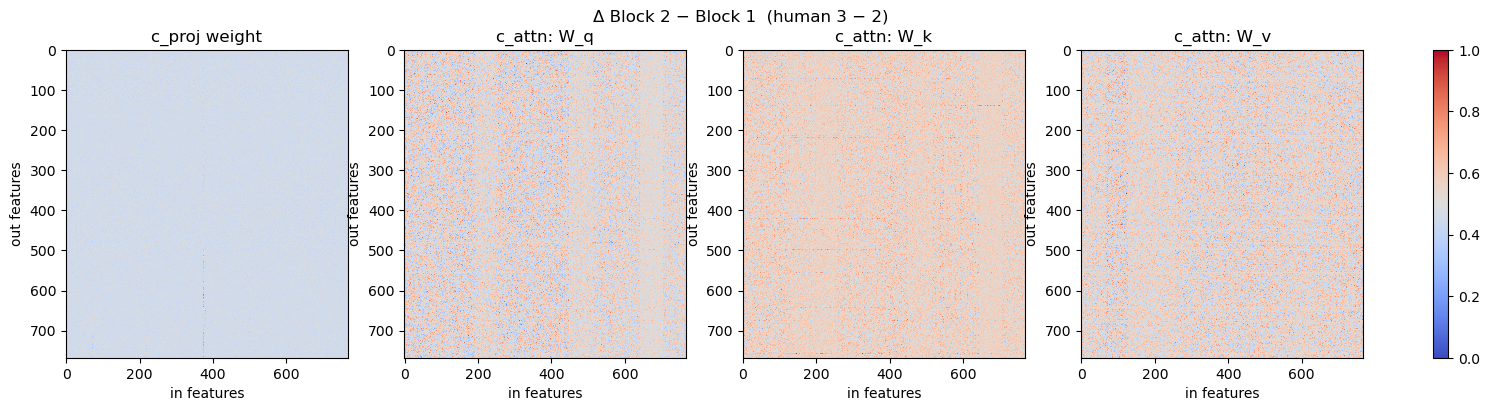

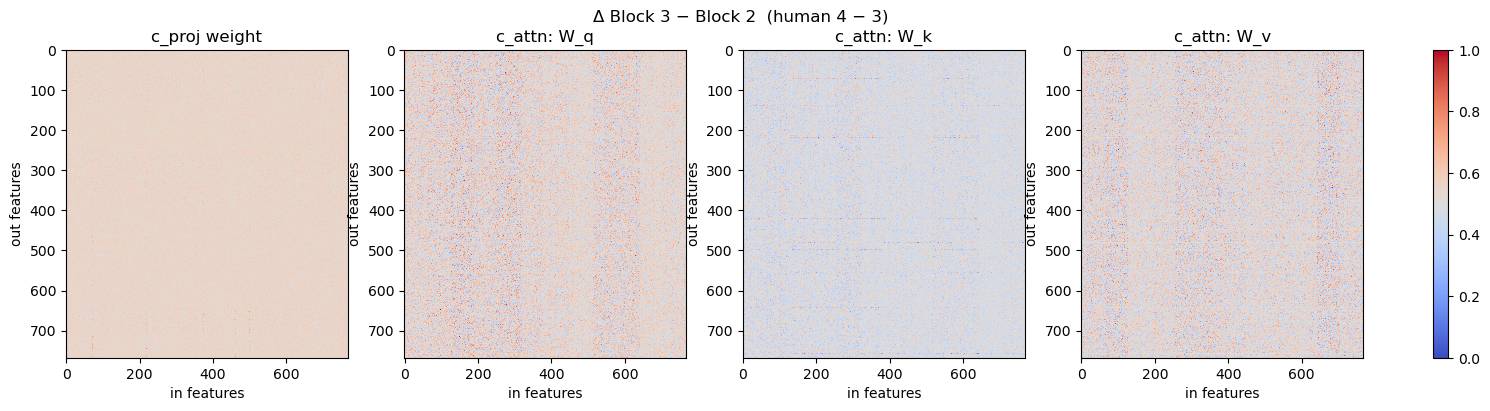

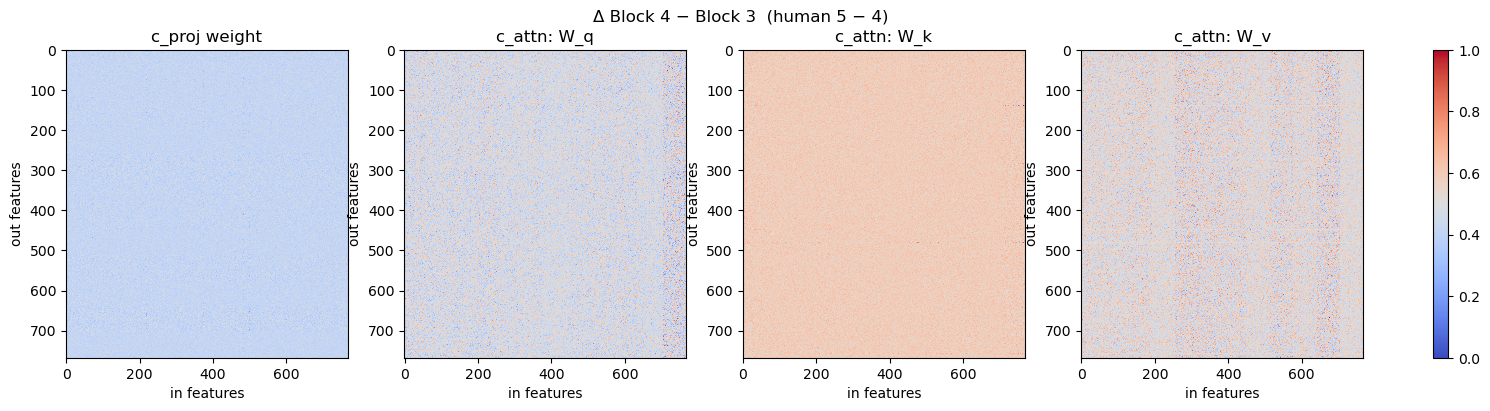

In [37]:
human_start = 2
human_end   = 4
start_idx   = human_start - 1
end_idx     = human_end - 1
n_blocks    = len(model.transformer.h)
start_idx   = max(0, start_idx)
end_idx     = min(n_blocks - 2, end_idx)  # <-- note -2 because we access i+1
assert start_idx <= end_idx, "Пустой диапазон блоков (нужно хотя бы две соседние слои)"

for i in range(start_idx, end_idx + 1):
    fig, axes = show_attn_weight_matrices_delta(model, layer_idx=i)
    fig.suptitle(f"Δ Block {i+1} − Block {i}  (human {i+2} − {i+1})")

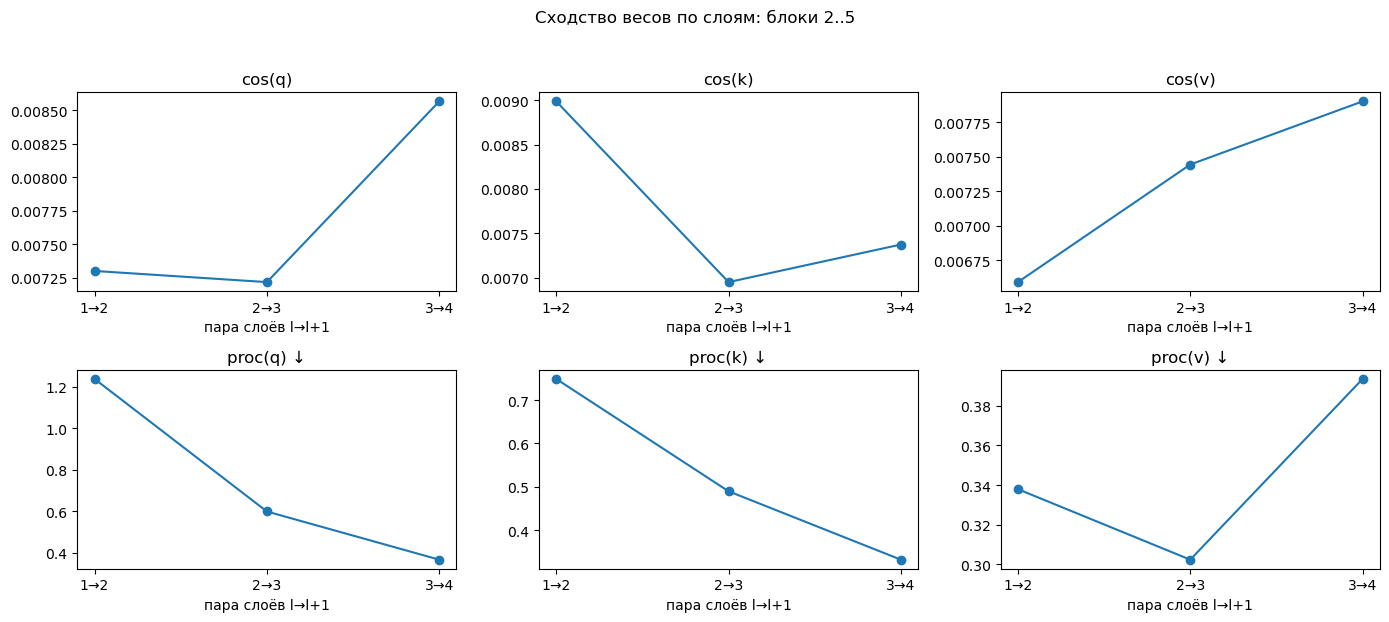

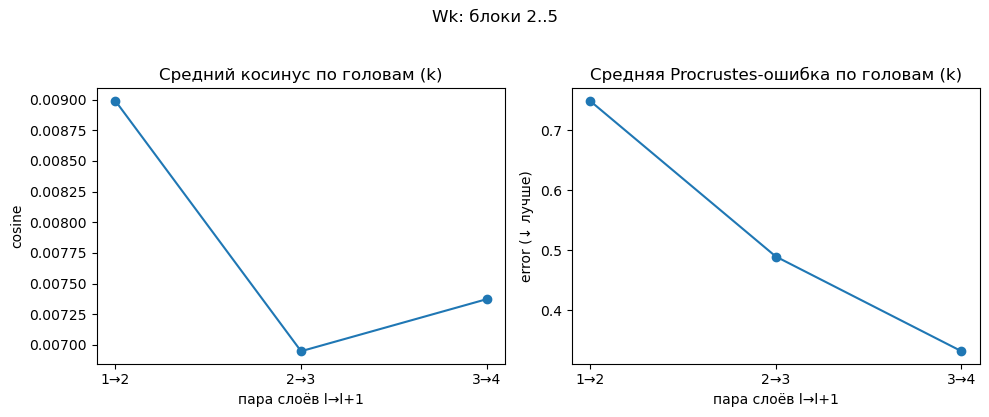

In [28]:
# человеческие номера 2..5 → python-индексы 1..4
human_start, human_end = 2, 5
start_idx = human_start - 1
end_idx   = human_end   - 1

# 1) панель для q/k/v сразу
_ = compare_blocks_range_all_three(
    model, start_idx, end_idx,
    transpose_for_math=True,   # как ты обычно смотришь матрицы
    plot=True,
    suptitle=f"Сходство весов по слоям: блоки {human_start}..{human_end}"
)

# 2) только, скажем, Wk — для детального анализа
_ = compare_blocks_range(
    model, start_idx, end_idx,
    which="k",
    transpose_for_math=True,
    plot=True,
    title=f"Wk: блоки {human_start}..{human_end}"
)

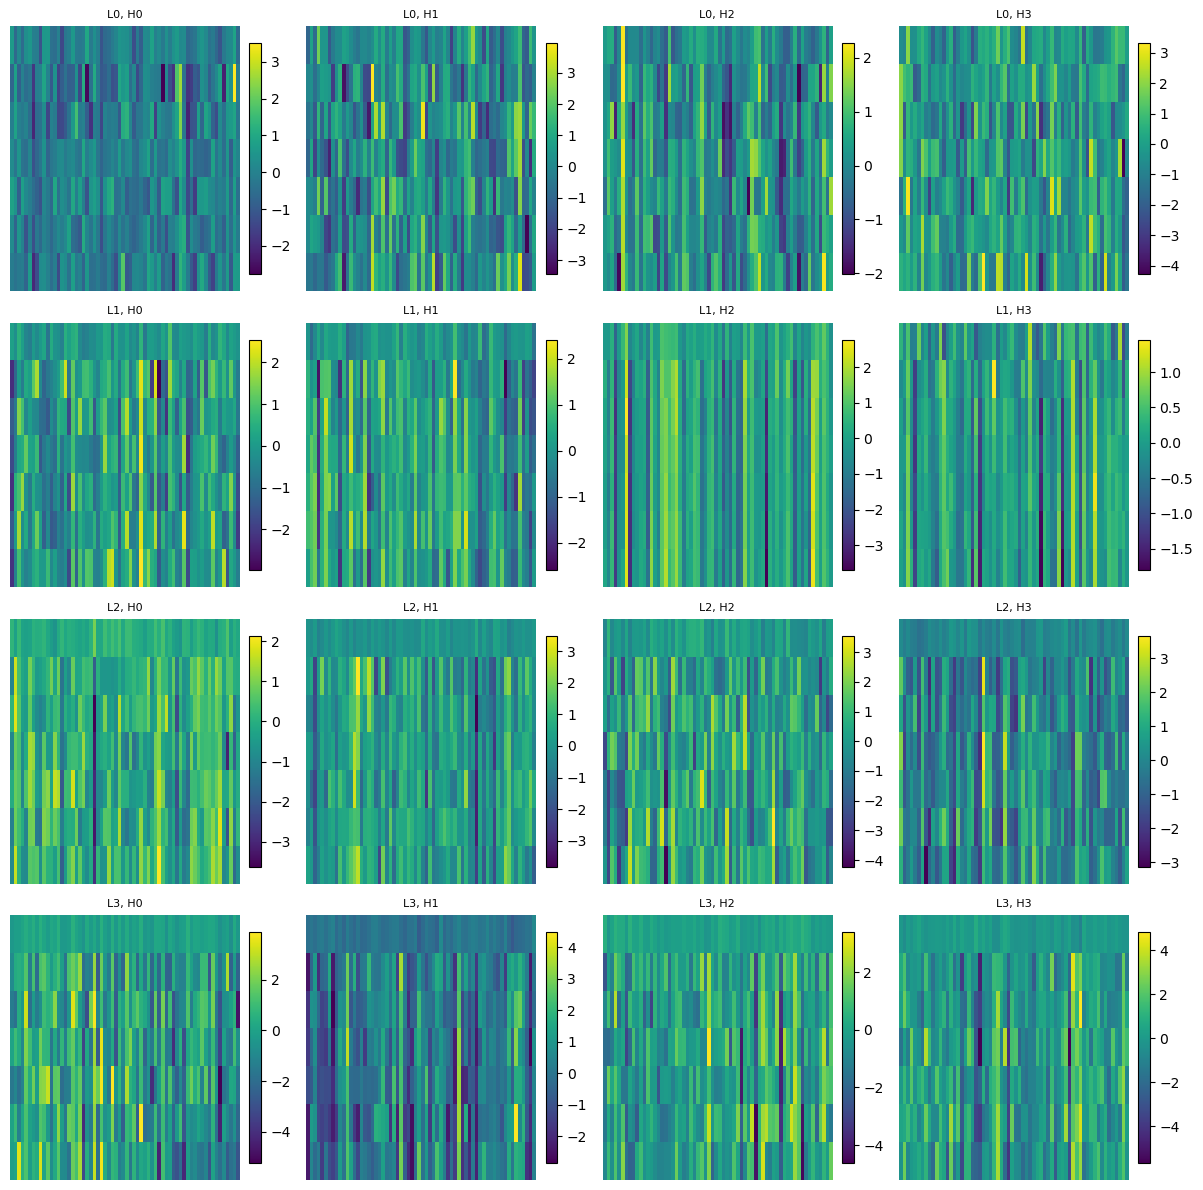

In [29]:
range_layer_idx = 4  # слой
num_head_idx = 4   # диапазон голов

fig, axes = plt.subplots(
    nrows=range_layer_idx,
    ncols=num_head_idx,
    figsize=(3 * num_head_idx, 3 * range_layer_idx)  # масштабируем по числу картинок
)

# если 1 строка или 1 столбец — привести axes к 2D
if range_layer_idx == 1:
    axes = np.expand_dims(axes, axis=0)
if num_head_idx == 1:
    axes = np.expand_dims(axes, axis=1)

for layer_idx in range(range_layer_idx):
    attn = model.transformer.h[layer_idx].attn
    for head_idx in range(num_head_idx):
        q = attn.last_q[0, head_idx]

        ax = axes[layer_idx, head_idx]
        im = ax.imshow(q, aspect='auto', interpolation='nearest')
        ax.set_title(f"L{layer_idx}, H{head_idx}", fontsize=8)
        ax.axis('off')  # убираем оси для компактности
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()   
plt.show()    


In [30]:
t2_itogo = tm.time()
print('при количестве создаваемых токенов ', max_new_tokens , 'и прогонов ', num_samples, 'весь код занял', round(t2_itogo - t1_itogo)//60,'минут', 
      round(t2_itogo - t1_itogo)%60,'секунд')

при количестве создаваемых токенов  1 и прогонов  1 весь код занял 0 минут 40 секунд


## Эти прорверочные блоки, если imshow не работает. Сейчас не нужны, оставим на всякий случай

In [31]:
# Это просто проврочный блок, чтобы понять, что матрица формируется и ее можно показать
q = attn.last_q  # тензор формы (B, nh, T, hs)
print("Q shape:", q.shape)
print("Q[0,0] shape:", q[0, 0].shape)  # одна голова, один батч — форма (T, hs)
print("Q[0,0][:2]:", q[0, 0][:2])  # первые две строки, чтобы не ронять ядро

Q shape: torch.Size([1, 12, 7, 64])
Q[0,0] shape: torch.Size([7, 64])
Q[0,0][:2]: tensor([[-0.3899, -0.1176, -0.1121,  0.0738,  0.3996,  0.0799,  0.4552, -0.0528,
          0.4957,  0.1265, -0.1914,  0.2435,  0.0478,  0.5265, -0.2891, -0.3352,
         -0.1548,  0.5457,  0.1012, -0.1485, -0.5234,  0.2964, -0.1841,  0.2399,
         -0.3351,  0.5274, -0.0898, -0.4184,  0.4317, -0.3235,  0.3208, -0.2691,
          0.3329, -0.3945,  0.0105, -0.1691,  0.4258, -0.4143, -0.1982, -0.4700,
          0.2438,  0.1715,  0.0686, -0.5857,  0.1398, -0.0860, -0.5122, -0.1675,
         -0.0876,  0.5123, -0.1848,  0.1185,  0.0902, -0.0977,  0.0663,  0.1931,
          0.1552, -0.0754, -0.6439, -0.2498, -0.0630, -0.6974,  0.2851, -0.3791],
        [-0.8491,  0.3541,  0.4961,  0.3271,  1.3946, -1.3684,  1.1847, -1.9661,
          1.2279,  1.5437,  0.7028, -0.2370,  0.5246,  1.1180, -0.1239, -1.7660,
          1.2453,  1.8304,  1.2193,  2.4731, -1.9003, -1.2415, -1.4864,  2.4462,
         -2.5880,  1.8417,

In [32]:
layer_idx = 0  # слой
attn = model.transformer.h[layer_idx].attn  # attention слой 0

# Достаём матрицу весов (3C × C)
W_cat = attn.c_attn.weight.detach().cpu()  # shape: (3C, C)

# Транспонируем, чтобы получить "человеческий" формат: (C, 3C)
W_cat = W_cat.T  # shape: (C, 3C)

# Получаем размерность C
C = attn.n_embd

# Разрезаем на 3 части: W_q, W_k, W_v
W_q = W_cat[:, :C]
W_k = W_cat[:, C:2*C]
W_v = W_cat[:, 2*C:]

# Показываем только форму и пару строк (без печати всей матрицы!)
print("W_q shape:", W_q.shape)
print("W_k shape:", W_k.shape)
print("W_v shape:", W_v.shape)

print("W_q[:2, :5] =\n", W_q[:2, :5])
print("W_k[:2, :5] =\n", W_k[:2, :5])
print("W_v[:2, :5] =\n", W_v[:2, :5])


W_q shape: torch.Size([768, 768])
W_k shape: torch.Size([768, 768])
W_v shape: torch.Size([768, 768])
W_q[:2, :5] =
 tensor([[-0.4738, -0.2614, -0.0978, -0.3499,  0.2243],
        [ 0.0874,  0.1473,  0.2387,  0.2884,  0.6491]])
W_k[:2, :5] =
 tensor([[ 0.3660,  0.0771,  0.2226,  0.0138, -0.0494],
        [-0.4380, -0.1446, -0.4717, -0.0253,  0.0490]])
W_v[:2, :5] =
 tensor([[ 0.1421,  0.0329, -0.0667,  0.0188, -0.0645],
        [ 0.0162, -0.0633, -0.0636,  0.0340, -0.0322]])
